#  Novel Time Series Primitive that Allows Real World Classification

## Contrast Profile

The tutorial is adapted from the [Matrix Profile XXIII paper](https://www.cs.ucr.edu/~eamonn/ContrastProfile_V048_names.pdf).  

Subsequence’s distance to its nearest neighbor within the same 
dataset can be represented by the [Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html).  

Time series **motifs** refer to two particularly **close** subsequences,  
whereas time series **discords** indicate subsequences that are **far** from their nearest neighbors.  

If a dataset has **more than one discords**, we have to know how those discords are calculated in Matrix Profile. 

Let's demonstrate it with ECG data in followoing condition .
- Matrix Profile on the first half of dataset which has **1 anomaly**.
- Matrix Profile on whole dataset which has **2 similar anomalies**.

In [1]:
import stumpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

df = pd.read_csv("ECG_demo.csv", index_col=0).astype(float)
T = df.values[:, 1]  # with 2 similar anomalies
m = 128  # window size as an example

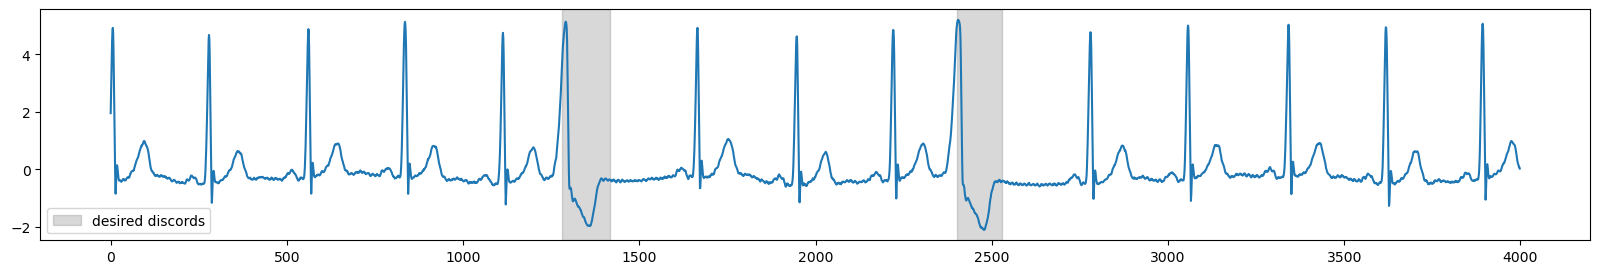

In [2]:
plt.figure(figsize=(20, 3))
plt.plot(T)
plt.axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
plt.axvspan(2400, 2400+m, color="grey", alpha=0.3)
plt.legend()
plt.show()

You can see two presence of novel patterns(PVCs) as discords. Those are target we try to find.
##### 1. Matrix Profile with **the first half** of dataset (which has 1 anomaly behavior.)

In [3]:
mp = stumpy.stump(T[:2000], m, normalize=False)
discord_idx = np.argmax(mp[:, 0])  # discords index
discord_nn_idx = mp[discord_idx, 1]  # discords nearest neighborhood index

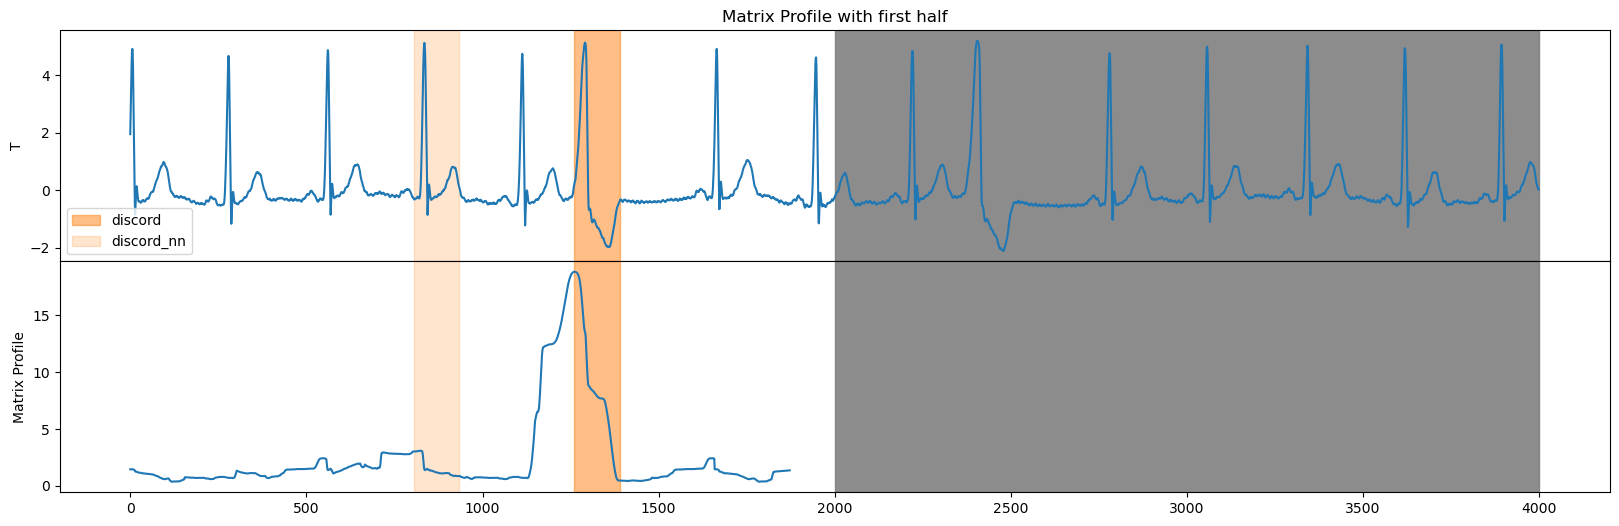

In [4]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(2000, 4000, color="grey", alpha=0.9)
axes[0].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[0].plot(T)
axes[1].axvspan(2000, 4000, color="grey", alpha=0.9)
axes[1].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[1].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[1].plot(mp[:, 0])
axes[0].legend()
axes[0].set_title("Matrix Profile with first half")
axes[0].set_ylabel("T")
axes[1].set_ylabel("Matrix Profile")
plt.show()

We can find clealy the discord by Matrix profile. It indicate the discord in Matrix profile by far.
##### 2. Matrix Profile with **whole dataset** (which has 2 anomaly behaviors.)

In [5]:
mp = stumpy.stump(T, m, normalize=False)
discord_idx = np.argmax(mp[:, 0])  # discords index
discord_nn_idx = mp[discord_idx, 1]  # discords nearest neighborhood index

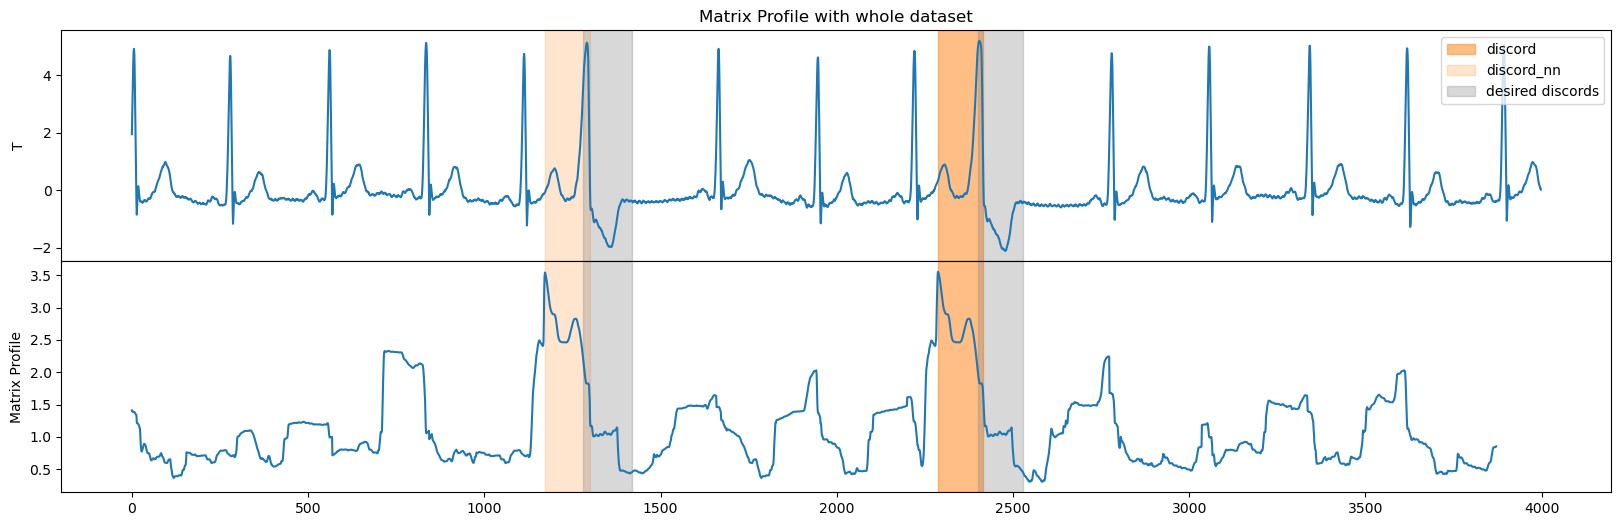

In [6]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[0].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
axes[0].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[0].plot(T)
axes[1].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[1].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[1].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
axes[1].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[1].plot(mp[:, 0])
axes[0].legend()
axes[0].set_title("Matrix Profile with whole dataset")
axes[0].set_ylabel("T")
axes[1].set_ylabel("Matrix Profile")
plt.show()

Matrix profile indicate slided wrong place as discords.   
Most important thing is Matrix profile also doesn't indicate remarkable distance for the discord.  
=> Because, desired discords have similar nearest_neighbor.

How can we find those 2 anormaly behaviors from the dataset. Those specification is followings.
- Those have close nearest neighbor in same data .
- Those is far from its nearest neighbor in **zero-instance of interest**.

This is exactly the property we desire.
In other words, we need to prepare two following dataset.
- **𝐓(+)**: contains  **at  least  two  instances**  that  are  unique  to the phenomena of interest. (It also include regular, obvious patterns.)
- **𝐓(−)**: contains **zero instances of interest**.  

Take a look at the plot below to confirm the condictions.


In [7]:
T_p = df.values[:, 1]  # T(+)
T_n = df.values[:, 0]  # T(-)

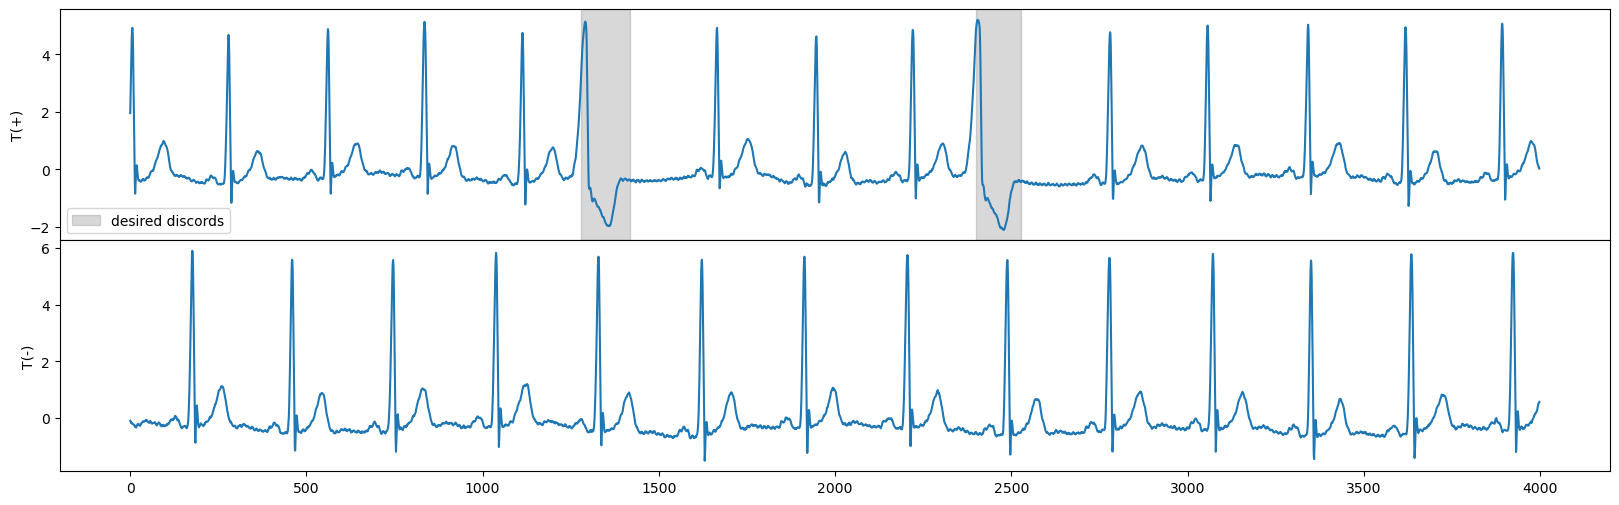

In [8]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
axes[0].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[0].plot(T_p)
axes[1].plot(T_n)
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("T(-)")
axes[0].legend()
plt.show()

We call these type of discoreds property (our interest) **Contrast**, and the vector that represents it the **Contrast Profile**.  

## Loading the ECG data for Contrast Profile
We proposed to compute the Contrast Profile **only when we belive that the two following assumptions are likely to be true:**
- 𝐓(+): contains  **at  least  two  instances**  that  are  unique  to the phenomena of interest. 
- 𝐓(−): contains **zero instances of interest**.  

We load two snippet T_pos: **T(+)** and T_neg: **T(-)**, Those are around 27-second snippet.  
Define index of desired instances on the purpose.  

In [9]:
ecg_df = pd.read_csv("ECG.csv", index_col=0).astype(float)
ecg_df.head(2)

,T(-),T(+)
0,30.0,-6.0
1,34.0,-8.0


In [10]:
T_n = ecg_df.iloc[:, 0].values  # T(-)
T_p = ecg_df.iloc[:, 1].values  # T(+)

m = 128
desired0_idx, desired1_idx = 550, 2030

## Visualizing the ECG snippets with desired instances.
This dataset is ECG of 75-year-old male.  
According to the doctors that annotated this datasets. 
there are two examples of PVC premature ventricular contractions.  
Those are instances we desire to find.


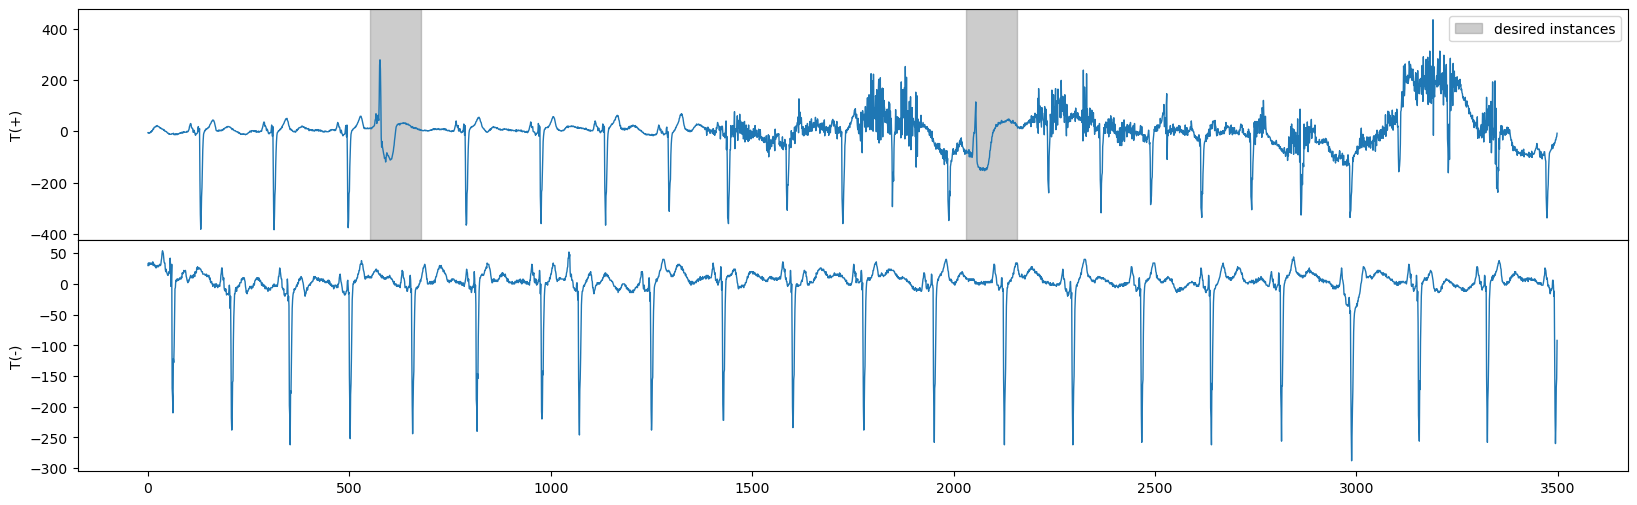

In [12]:
fig, axis = plt.subplots(2, 1, gridspec_kw={"hspace":0})
axis[0].plot(T_p, linewidth=1)
axis[1].plot(T_n, linewidth=1)
axis[0].axvspan(desired0_idx, desired0_idx+m, color="grey", alpha=0.4, label="desired instances")
axis[0].axvspan(desired1_idx, desired1_idx+m, color="grey", alpha=0.4)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("T(-)")
axis[0].legend(loc=1)

plt.show()

[Upper Fig] : T(+) contains at least two instances that are of our interest. Signals on grey area are two "desired instances" which are similar.  

[Bottom Fig] : T(-) looks clean, much more regular repeated pattern. Because T(-) has to be **zero instances of interest**.

## What can Matrix Profile(self-join) find?
Let's demonstrate which kind of motifs/discords self-join Matrix Profile for T(+) can find.

In [13]:
MP_PP = stumpy.stump(T_p, m)
motif_idx = np.argmin(MP_PP[:, 0])
motif_nn_idx = MP_PP[motif_idx, 1]
discord_idx = np.argmax(MP_PP[:, 0])
discord_nn_idx = MP_PP[discord_idx, 1]

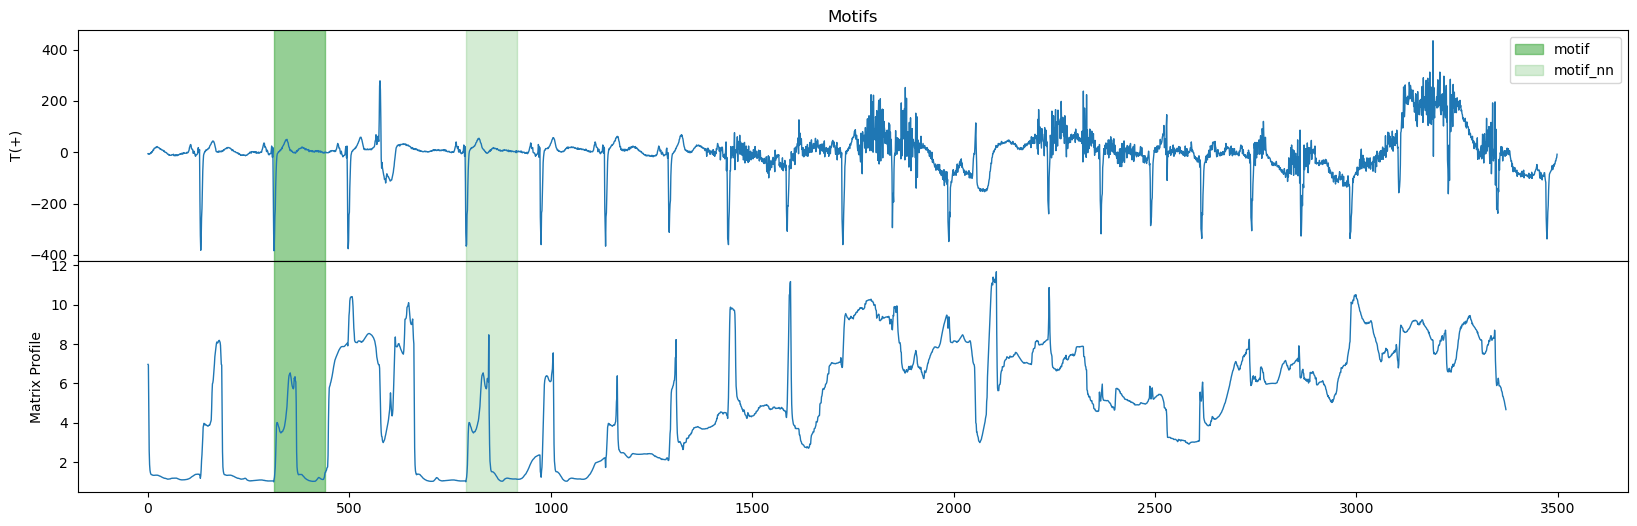

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axes[0].plot(T_p, linewidth=1)
axes[1].plot(MP_PP[:, 0], linewidth=1)

axes[0].axvspan(motif_idx, motif_idx+m, color="C2", alpha=0.5, label="motif")
axes[1].axvspan(motif_idx, motif_idx+m, color="C2", alpha=0.5)
axes[0].axvspan(motif_nn_idx, motif_nn_idx+m, color="C2", alpha=0.2, label="motif_nn")
axes[1].axvspan(motif_nn_idx, motif_nn_idx+m, color="C2", alpha=0.2)
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("Matrix Profile")
axes[0].legend(loc=1)
axes[0].set_title("Motifs")
plt.show()

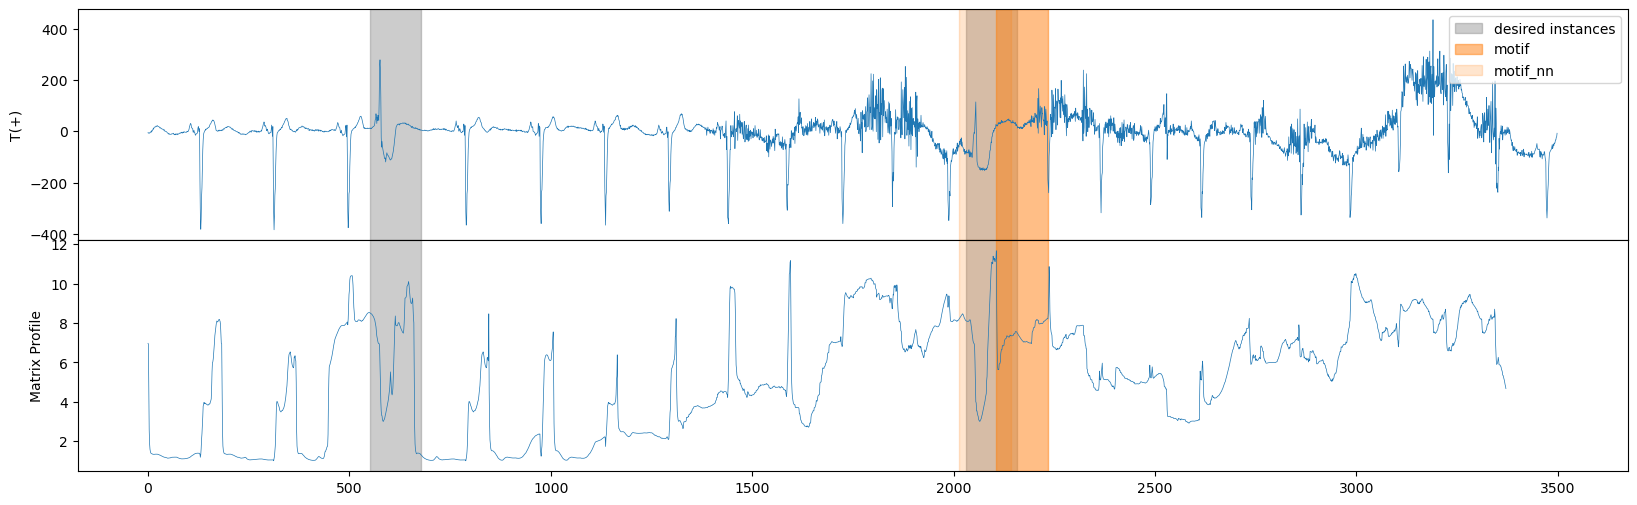

In [15]:
fig, axis = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axis[0].plot(T_p, linewidth=0.5)
axis[1].plot(MP_PP[:, 0], linewidth=0.5)
axis[0].axvspan(desired0_idx, desired0_idx+m, color="grey", alpha=0.4, label="desired instances")
axis[1].axvspan(desired0_idx, desired0_idx+m, color="grey", alpha=0.4)
axis[0].axvspan(desired1_idx, desired1_idx+m, color="grey", alpha=0.4)
axis[1].axvspan(desired1_idx, desired1_idx+m, color="grey", alpha=0.4)

axis[0].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="motif")
axis[1].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5)
axis[0].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="motif_nn")
axis[1].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("Matrix Profile")
axis[0].legend(loc=1)
plt.show()

While these two beats(desired instances) are similar, they are not as well conserved as normal beats.